In [ ]:
# Лабораторна робота №3. Регресія
# Автор: Байков Олександр Сергійович ФІТ 4-11
# На парі  був

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [6]:
from google.colab import files
import pandas as pd
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)
print(data.head())


Saving house_price_regression_dataset (1).csv to house_price_regression_dataset (1) (1).csv
   Square_Footage  Num_Bedrooms  Num_Bathrooms  Year_Built  Lot_Size  \
0            1360             2              1        1981  0.599637   
1            4272             3              3        2016  4.753014   
2            3592             1              2        2016  3.634823   
3             966             1              2        1977  2.730667   
4            4926             2              1        1993  4.699073   

   Garage_Size  Neighborhood_Quality   House_Price  
0            0                     5  2.623829e+05  
1            1                     6  9.852609e+05  
2            0                     9  7.779774e+05  
3            1                     8  2.296989e+05  
4            0                     8  1.041741e+06  


In [7]:
# Перегляд перших рядків
data.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


In [8]:
# Перевірка на дублікати та пропуски
print("Дублікати:", data.duplicated().sum())
print("Пропущені значення:\n", data.isnull().sum())


Дублікати: 0
Пропущені значення:
 Square_Footage          0
Num_Bedrooms            0
Num_Bathrooms           0
Year_Built              0
Lot_Size                0
Garage_Size             0
Neighborhood_Quality    0
House_Price             0
dtype: int64


In [9]:
# Основна статистика
print(data.describe())

       Square_Footage  Num_Bedrooms  Num_Bathrooms   Year_Built     Lot_Size  \
count     1000.000000   1000.000000    1000.000000  1000.000000  1000.000000   
mean      2815.422000      2.990000       1.973000  1986.550000     2.778087   
std       1255.514921      1.427564       0.820332    20.632916     1.297903   
min        503.000000      1.000000       1.000000  1950.000000     0.506058   
25%       1749.500000      2.000000       1.000000  1969.000000     1.665946   
50%       2862.500000      3.000000       2.000000  1986.000000     2.809740   
75%       3849.500000      4.000000       3.000000  2004.250000     3.923317   
max       4999.000000      5.000000       3.000000  2022.000000     4.989303   

       Garage_Size  Neighborhood_Quality   House_Price  
count  1000.000000           1000.000000  1.000000e+03  
mean      1.022000              5.615000  6.188610e+05  
std       0.814973              2.887059  2.535681e+05  
min       0.000000              1.000000  1.116269e

/tmp/ipython-input-2157597963.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Neighborhood_Quality', palette='viridis')


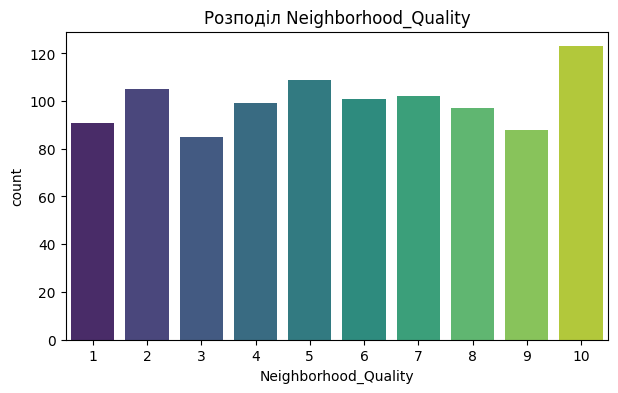

In [10]:
# Розподіл якості району
plt.figure(figsize=(7,4))
sns.countplot(data=data, x='Neighborhood_Quality', palette='viridis')
plt.title("Розподіл Neighborhood_Quality")
plt.show()


/tmp/ipython-input-2968955744.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Num_Bathrooms', palette='magma')


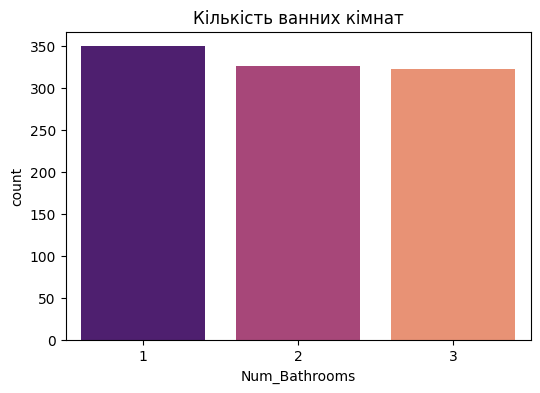

In [11]:
# Перевірка кількості ванних кімнат
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='Num_Bathrooms', palette='magma')
plt.title("Кількість ванних кімнат")
plt.show()

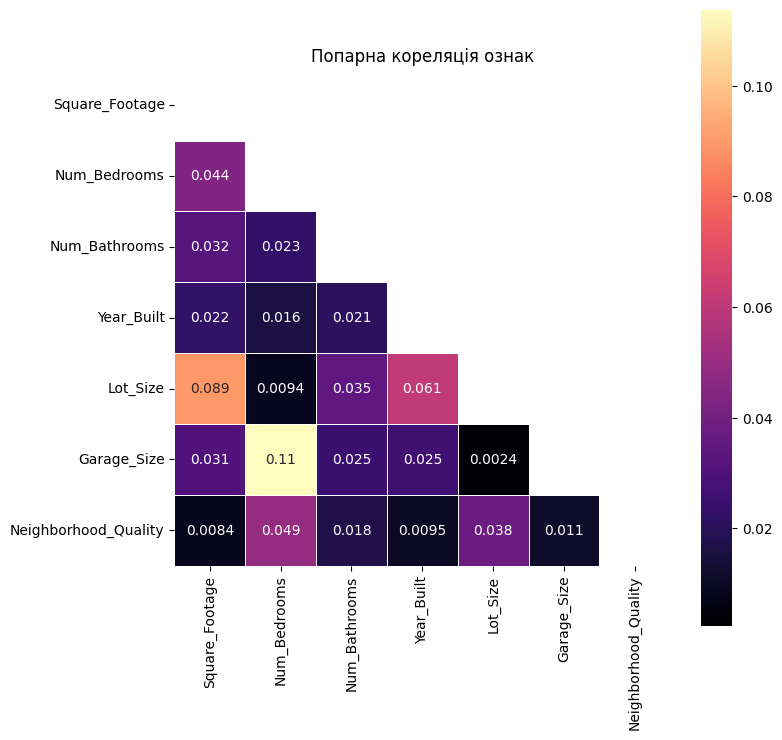

In [15]:
# Матриця кореляції між ознаками з новим кольором
features_corr = data.drop(columns=['House_Price']).corr().abs()

plt.figure(figsize=(8,8))
sns.heatmap(
    features_corr,
    annot=True,
    cmap='magma',
    mask=np.triu(np.ones_like(features_corr, dtype=bool)),
    square=True,
    linewidths=0.5
)
plt.title("Попарна кореляція ознак")
plt.show()

In [16]:
# Кореляція ознак з цільовою змінною
target_corr = data.corr()['House_Price'].sort_values(ascending=False)
print("Кореляція з House_Price:\n", target_corr)


Кореляція з House_Price:
 House_Price             1.000000
Square_Footage          0.991261
Lot_Size                0.160412
Garage_Size             0.052133
Year_Built              0.051967
Num_Bedrooms            0.014633
Num_Bathrooms          -0.001862
Neighborhood_Quality   -0.007770
Name: House_Price, dtype: float64


In [20]:
# Відокремлюємо ознаки і цільову змінну
X = data.drop(columns=['House_Price'])
y = data['House_Price']

In [22]:
# Масштабування ознак
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# Розділення на тренувальні та тестові дані
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [33]:
# Ініціалізація моделей
model_dict = {
    "Лінійна регресія": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Випадковий ліс": RandomForestRegressor(),
    "Градієнтний бустинг": GradientBoostingRegressor()
}

results = {}

In [34]:
# Навчання моделей та оцінка
for name, model in model_dict.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results[name] = {
        "model": model,
        "predictions": preds,
        "R2_train": model.score(X_train, y_train),
        "MAE": mean_absolute_error(y_test, preds),
        "MSE": mean_squared_error(y_test, preds)
    }

    print(f"[{name}] R² тренувальні: {results[name]['R2_train']:.6f} | MAE: {results[name]['MAE']:.2f} | MSE: {results[name]['MSE']:.2f}")

[Лінійна регресія] R² тренувальні: 0.998538 | MAE: 8174.58 | MSE: 101434798.51
[Ridge] R² тренувальні: 0.998536 | MAE: 8241.90 | MSE: 102486578.62
[Lasso] R² тренувальні: 0.998538 | MAE: 8174.61 | MSE: 101435079.24
[Випадковий ліс] R² тренувальні: 0.998969 | MAE: 15972.47 | MSE: 391383561.39
[Градієнтний бустинг] R² тренувальні: 0.998783 | MAE: 12346.48 | MSE: 226395951.32


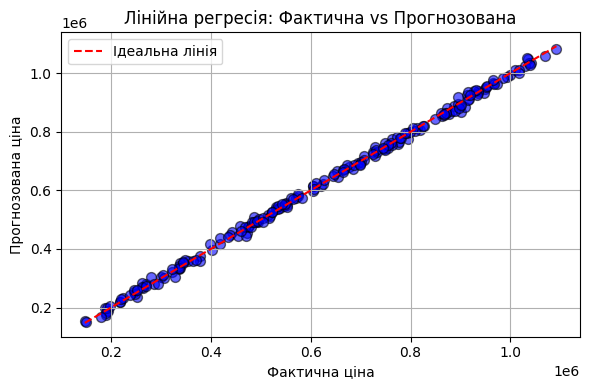

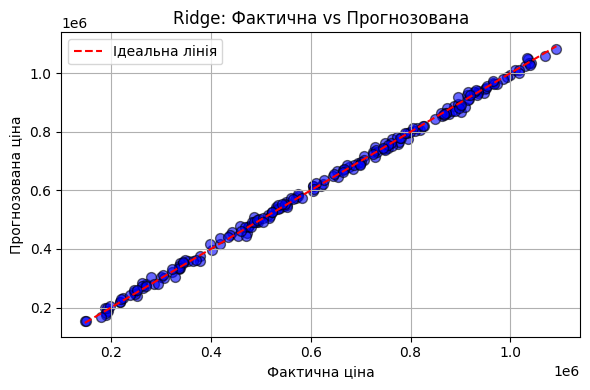

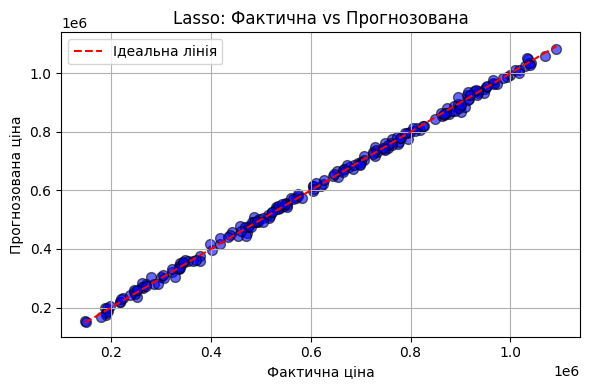

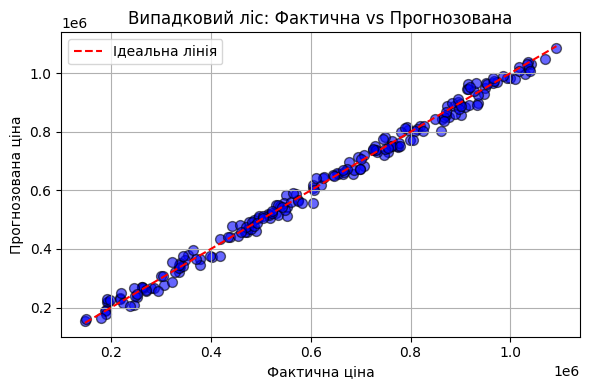

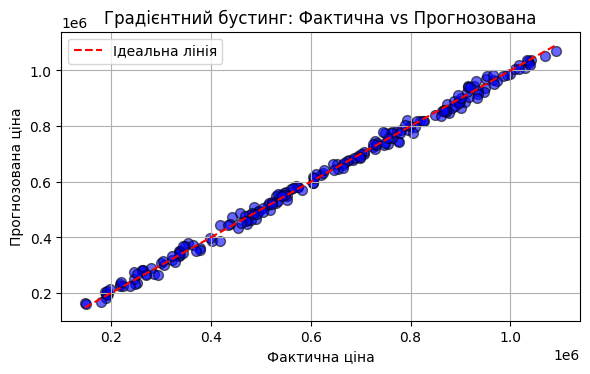

In [41]:
# Графіки фактичних та передбачених значень
for name, res in results.items():
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, res["predictions"], alpha=0.6, edgecolor='k', color='blue', s=50)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ідеальна лінія')
    plt.xlabel("Фактична ціна")
    plt.ylabel("Прогнозована ціна")
    plt.title(f"{name}: Фактична vs Прогнозована")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [42]:
# Підбір оптимальних параметрів для Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid=param_grid_rf, cv=3)
grid_search_rf.fit(X_train, y_train)

best_params = grid_search_rf.best_params_
print("Оптимальні параметри Random Forest:", best_params)

Оптимальні параметри Random Forest: {'max_depth': 10, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}


In [43]:
# Навчання оптимальної моделі Random Forest
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)
rf_preds = rf_best.predict(X_test)

In [44]:
# Метрики оптимальної моделі
print("MSE:", mean_squared_error(y_test, rf_preds))
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("R2:", r2_score(y_test, rf_preds))


MSE: 400038896.87978363
MAE: 16137.413976430662
R2: 0.99379388783849


In [46]:
# Порівняння передбачень Лінійної регресії
lin_preds = results["Лінійна регресія"]["predictions"]
comparison = pd.DataFrame({
    "Фактична ціна": y_test.values,
    "Прогнозована ціна": lin_preds
})
comparison["Похибка, %"] = np.abs(comparison["Прогнозована ціна"] - comparison["Фактична ціна"]) / comparison["Фактична ціна"] * 100
print(comparison.sample(10, random_state=42).round(2))

     Фактична ціна  Прогнозована ціна  Похибка, %
95      1068538.11         1059729.02        0.82
15       194353.74          187868.55        3.34
30       270230.64          279715.82        3.51
158      986006.86          981949.27        0.41
128      953339.73          957382.95        0.42
115      914555.75          909764.27        0.52
69       746167.73          742469.14        0.50
170      646766.29          654445.55        1.19
174      523323.07          524605.44        0.25
45      1008539.16         1011343.64        0.28


In [ ]:
# Висновок

# Аналіз датасету показав, що ціна будинку майже повністю залежить від площі (Square_Footage, кореляція 0.991), а інші ознаки (Lot_Size, Garage_Size, Year_Built, кількість кімнат, кількість ванних, Neighborhood_Quality) практично не впливають на ціну.
# Лінійні моделі (LinearRegression, Ridge, Lasso) показали дуже високу точність на тренувальних даних (R² ~0.9985, MAE ~8 200), що підтверджує лінійну залежність ціни від площі. Random Forest і Gradient Boosting також добре передбачають ціни, зберігаючи стабільність на тестових даних, хоча MAE дещо вищий через регуляризацію і узагальнення.
# Аналіз похибок прогнозів лінійної регресії показав, що для більшості будинків похибка менше 1%, а максимальна — 3.5%. Графіки фактичних vs прогнозованих цін підтверджують, що моделі відтворюють розподіл цін дуже точно.
